In [21]:
from sklearn.svm import SVC
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import mglearn
import numpy as np

In [7]:
cancer = load_breast_cancer()
X_train,X_test,y_train,y_test = train_test_split(cancer.data, cancer.target, random_state = 0)
scaler = MinMaxScaler().fit(X_train,y_train)

In [8]:
X_train_scaled = scaler.transform(X_train)
svm = SVC()
svm.fit(X_train_scaled,y_train)
X_test_scaled = scaler.transform(X_test)
print('Correctness on the test set: {:.2f}'.format(svm.score(X_test_scaled,y_test)))

Correctness on the test set: 0.95


/Users/vlad3d/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


In [9]:
from sklearn.model_selection import GridSearchCV
#not use this code!!!
param_grid = {'C':[0.001,0.01,0.1,1,10,100], 'gamma':[0.001,0.01,0.1,1,10,100]}
grid = GridSearchCV(SVC(), param_grid=param_grid, cv=5)
grid.fit(X_train_scaled, y_train)
print("Finden values of cross validation: {:.2f}".format(grid.best_score_))
print("Finden correctness values on test: {:.2f}".format(grid.score(X_test_scaled, y_test)))
print("Finded params", grid.best_params_)

Finden values of cross validation: 0.98
Finden correctness values on test: 0.97
Finded params {'C': 1, 'gamma': 1}


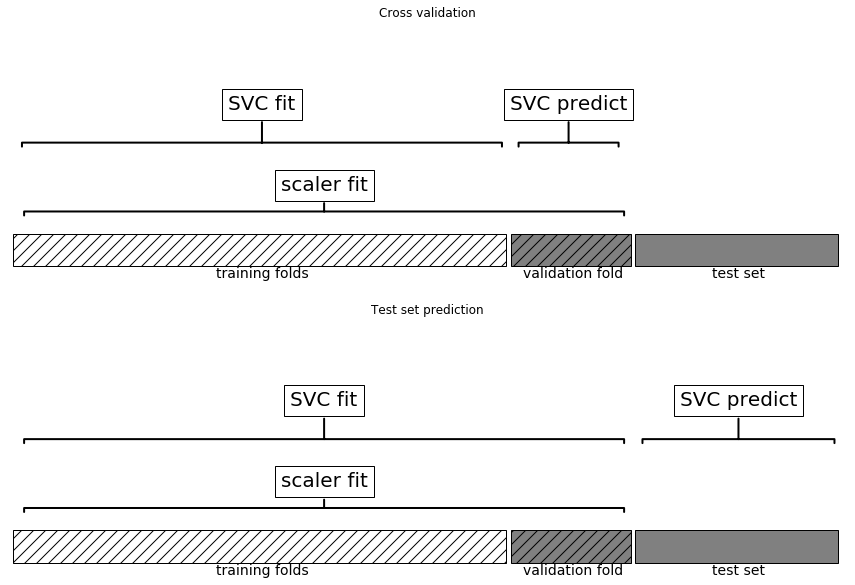

In [11]:
mglearn.plots.plot_improper_processing()

## CONVEYOR BUILDING

In [13]:
from sklearn.pipeline import Pipeline
pipe = Pipeline([('scaler',MinMaxScaler()),('svm',SVC())])
pipe.fit(X_train,y_train)

/Users/vlad3d/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


Pipeline(memory=None,
     steps=[('scaler', MinMaxScaler(copy=True, feature_range=(0, 1))), ('svm', SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
  kernel='rbf', max_iter=-1, probability=False, random_state=None,
  shrinking=True, tol=0.001, verbose=False))])

In [14]:
print('Correctness on test set: {:.2f}'.format(pipe.score(X_test,y_test)))

Correctness on test set: 0.95


### USING CONVEYOUR WITH GRIDSEARCHCV

In [17]:
param_grid = {'svm__C':[0.001,0.01,0.1,1,10,100], 'svm__gamma':[0.001,0.01,0.1,1,10,100]}
grid = GridSearchCV(pipe, param_grid=param_grid, cv=5)
grid.fit(X_train, y_train)
print("Finden values of cross validation: {:.2f}".format(grid.best_score_))
print("Finden correctness values on test: {:.2f}".format(grid.score(X_test, y_test)))
print("Finded params", grid.best_params_)

Finden values of cross validation: 0.98
Finden correctness values on test: 0.97
Finded params {'svm__C': 1, 'svm__gamma': 1}


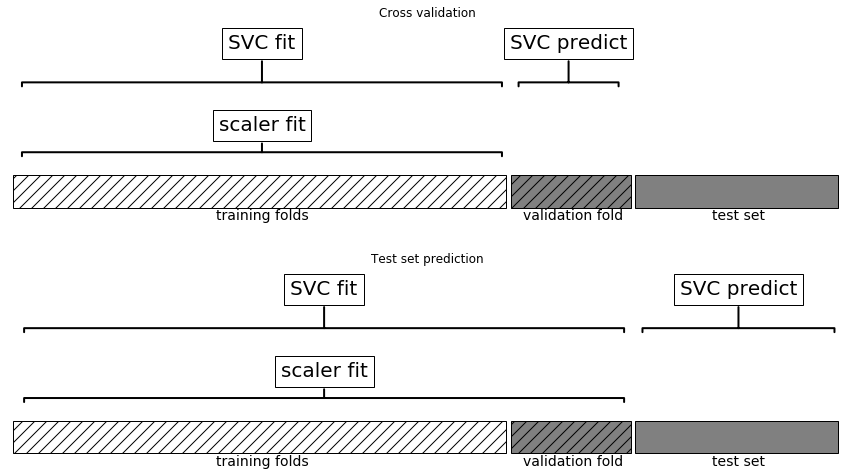

In [18]:
mglearn.plots.plot_proper_processing()

### DATA LEAKAGE EXAMPLE

In [26]:
rnd = np.random.RandomState(seed=0)
X = rnd.normal(size=(100,10000))
y = rnd.normal(size=(100,))

In [27]:
from sklearn.feature_selection import SelectPercentile,f_regression
select = SelectPercentile(score_func=f_regression,percentile=5).fit(X,y)
X_selected = select.transform(X)
print('X_selected array shape: {}'.format(X_selected.shape))

X_selected array shape: (100, 500)


In [28]:
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import Ridge
print("R^2 cross vlidation rof ridge: {:.2f}".format(np.mean(cross_val_score(Ridge(),X_selected,y,cv=5))))


R^2 cross vlidation rof ridge: 0.91


In [29]:
pipe = Pipeline([('select',SelectPercentile(score_func=f_regression,percentile=5)),('ridge',Ridge())])
print("R^2 cross vlidation rof conveyour: {:.2f}".format(np.mean(cross_val_score(pipe,X_selected,y,cv=5))))


R^2 cross vlidation rof conveyour: -0.17


### CONVEYOUR INTERFACE

In [30]:
def fit(self,X,y):
    X_transformed = X
    for name,estimator in self.steps[:-1]:
        X_transformed = estimator.fit_transform(X_transformed,y)
    self.steps[-1][1].fit(X_transformed,y)
    return self

In [31]:
def predict(self,X):
    X_transformed = X
    for step in self.steps[:-1]:
        X_transformed = step[1].transform(X_transformed)
    return self.steps[-1][1].predict(X_transformed)

### MAKE PIPELINE FUNCTION

In [32]:
from sklearn.pipeline import make_pipeline
pipe_long = Pipeline([('scaler',MinMaxScaler()),('svm',SVC(C=100))])
pipe_short = make_pipeline(MinMaxScaler(),SVC(C=100))

In [33]:
print('Conveyour steps:\n{}'.format(pipe_short.steps))

Conveyour steps:
[('minmaxscaler', MinMaxScaler(copy=True, feature_range=(0, 1))), ('svc', SVC(C=100, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
  kernel='rbf', max_iter=-1, probability=False, random_state=None,
  shrinking=True, tol=0.001, verbose=False))]


In [34]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
pipe = make_pipeline(StandardScaler(),PCA(n_components=2), StandardScaler())
print('Conveyour steps:\n{}'.format(pipe.steps))

Conveyour steps:
[('standardscaler-1', StandardScaler(copy=True, with_mean=True, with_std=True)), ('pca', PCA(copy=True, iterated_power='auto', n_components=2, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)), ('standardscaler-2', StandardScaler(copy=True, with_mean=True, with_std=True))]


In [35]:
pipe.fit(cancer.data)
components = pipe.named_steps['pca'].components_
print('components shape: {}'.format(components.shape))

components shape: (2, 30)


In [36]:
from sklearn.linear_model import LogisticRegression
pipe = make_pipeline(StandardScaler(),LogisticRegression())

In [39]:
param_grid = {'logisticregression__C':[0.01,0.1,1,10,100]}
X_train, X_test, y_train, y_test = train_test_split( cancer.data, cancer.target, random_state=4)
grid = GridSearchCV(pipe,param_grid,cv=5)
grid.fit(X_train,y_train)

/Users/vlad3d/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/vlad3d/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/vlad3d/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/vlad3d/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/vlad3d/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to '

GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=Pipeline(memory=None,
     steps=[('standardscaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('logisticregression', LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False))]),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'logisticregression__C': [0.01, 0.1, 1, 10, 100]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [40]:
print('Best model:\n{}'.format(grid.best_estimator_))

Best model:
Pipeline(memory=None,
     steps=[('standardscaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('logisticregression', LogisticRegression(C=0.1, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False))])


In [41]:
print('Logistic regression fase:\n{}'.format(grid.best_estimator_.named_steps['logisticregression']))


Logistic regression fase:
LogisticRegression(C=0.1, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)


In [42]:
print('Logistic regressions coefficients:\n{}'.format(grid.best_estimator_.named_steps['logisticregression'].coef_))


Logistic regressions coefficients:
[[-0.38856355 -0.37529972 -0.37624793 -0.39649439 -0.11519359  0.01709608
  -0.3550729  -0.38995414 -0.05780518  0.20879795 -0.49487753 -0.0036321
  -0.37122718 -0.38337777 -0.04488715  0.19752816  0.00424822 -0.04857196
   0.21023226  0.22444999 -0.54669761 -0.52542026 -0.49881157 -0.51451071
  -0.39256847 -0.12293451 -0.38827425 -0.4169485  -0.32533663 -0.13926972]]


In [43]:
from sklearn.datasets import load_boston
boston = load_boston()
X_train, X_test, y_train, y_test = train_test_split(boston.data, boston.target,
                                                    random_state=0)

In [44]:
from sklearn.preprocessing import PolynomialFeatures
pipe = make_pipeline(StandardScaler(),PolynomialFeatures(),Ridge())

In [45]:
param_grid = {'polynomialfeatures__degree':[1,2,3],
             'ridge__alpha':[0.001,0.01,0.1,1,10,100]}

In [46]:
grid = GridSearchCV(pipe,param_grid=param_grid,cv=5,n_jobs=-1)
grid.fit(X_train,y_train)

GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=Pipeline(memory=None,
     steps=[('standardscaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('polynomialfeatures', PolynomialFeatures(degree=2, include_bias=True, interaction_only=False)), ('ridge', Ridge(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=None, solver='auto', tol=0.001))]),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid={'polynomialfeatures__degree': [1, 2, 3], 'ridge__alpha': [0.001, 0.01, 0.1, 1, 10, 100]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

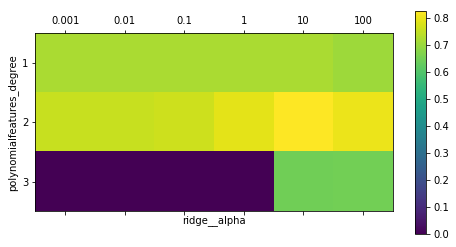

In [48]:
import matplotlib.pyplot as plt
plt.matshow(grid.cv_results_['mean_test_score'].reshape(3,-1),vmin=0,cmap='viridis')
plt.xlabel('ridge__alpha')
plt.ylabel('polynomialfeatures_degree')
plt.xticks(range(len(param_grid['ridge__alpha'])),param_grid['ridge__alpha'])
plt.yticks(range(len(param_grid['polynomialfeatures__degree'])),param_grid['polynomialfeatures__degree'])

plt.colorbar()

In [49]:
print('Best parameters:{}'.format(grid.best_params_))

Best parameters:{'polynomialfeatures__degree': 2, 'ridge__alpha': 10}


In [50]:
print("R square on test set: {:.2f}".format(grid.score(X_test,y_test)))

R square on test set: 0.77


In [58]:
param_grid = {'ridge__alpha':[0.001,0.01,0.1,1,10,100]}
pipe = make_pipeline(StandardScaler(),Ridge())
grid = GridSearchCV(pipe,param_grid,cv=5)
grid.fit(X_train,y_train)
print('R^2 without polynomial: {:.2f}'.format(grid.score(X_test,y_test)))

R^2 without polynomial: 0.73


In [59]:
pipe = Pipeline([('preprocessing',StandardScaler()), ('classifier',SVC())])

In [60]:
from sklearn.ensemble import RandomForestClassifier
param_grid = [{'classifier':[SVC()], 'preprocessing':[StandardScaler(),None],
              'classifier__gamma':[0.001,0.01,0.1,1,10,100],
              'classifier__C':[0.001,0.01,0.1,1,10,100]},
             {'classifier':[RandomForestClassifier(n_estimators=100)],
             'preprocessing':[None], 'classifier__max__features':[1,2,3]}]

In [62]:
X_train, X_test, y_train, y_test = train_test_split( cancer.data, cancer.target, random_state=0)
grid = GridSearchCV(pipe,param_grid,cv=5)
grid.fit(X_train,y_train)
print('Best params:\n{}\n'.format(grid.best_params_))